## Delayed stabilzier measurements and their effect on the QEC
In our thesis, we investigated the performance of the smallest possible quantum error correcting code (QECC) capable of correcting any single qubit error. This code, the $[\![5,1,3]\!]$ stabilizer code, could be a potentially interesting test case for error correction on near-term hardware. We identified the main bottleneck as a form of decoding error cause by noise occuring in-between the stabilizer measurements.
 
# Recap of the code
The code uses five qubits to redundantly store the information of a single logical qubit. Errors are detected using the four stabilizer generators
$$
g_{1} = X Z Z X I \\
g_{2} = I X Z Z X \\
g_{3} = X I X Z Z \\
g_{4} = Z X I X Z.
$$
These are Hermitian observables with eigenvalues $+1$ and $-1$, and error-free states are defined as the simultaneous eigenvectors with an eigenvalue of $+1$ for each of them (they are said to be stabilized). Measuring these four observables, using the circuit below, gives a four bit string (we refer to $+1$ outcomes as $'0'$ and $-1$ as $'1'$ and write the measurements from right to left) which uniquely identifies every single qubit Pauli error on any of the qubits. Here, $'0000'$ signifies an error free state and e.g. $'0110'$ signifies the occurance of $X_4$, i.e. a bit-flip error on the fourth qubit. 

*(This embedded image cannot be rendered by vscode)*

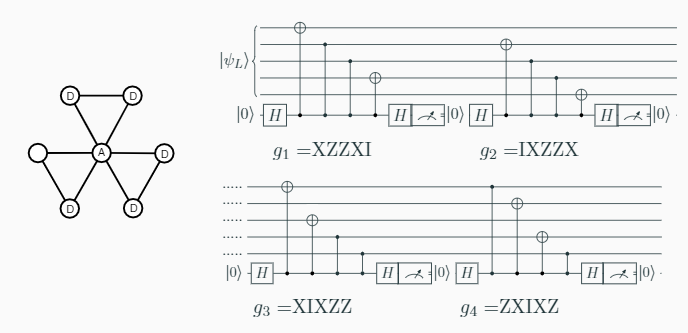

/home/sebastian/miniconda3/envs/exjobb-qiskit/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


Adding custom device equivalences
frozenset({('final_measure', False), ('include_barriers', True), ('conditional', False), ('idle_delay', 'before'), ('recovery', True), ('reset', True), ('include_fifth_stabilizer', False), ('encoding', False), ('generator_snapshot', True), ('n_cycles', 3), ('idle_snapshots', 2)})
[40000.0, 40000.0, 40000.0, 40000.0, 40000.0, 100000000000, 100000000000]
frozenset({('swap', 0), ('reset', 0), ('feedback', 0), ('split', 0), ('cx', 0), ('z', 20), ('delay', 5000), ('measure', 0), ('sz', 20), ('unitary', 0), ('u2', 20), ('u3', 20), ('set_density_matrix', 0), ('save_expval_var', 0), ('barrier', 0), ('save_density_matrix', 0), ('snapshot', 0), ('ry', 20), ('sx', 20), ('save_expval', 0), ('t', 20), ('x', 20), ('iswap', 0), ('y', 20), ('sy', 20), ('h', 20), ('s', 20), ('cz', 0), ('u1', 20)}) 

frozenset({('final_measure', False), ('include_barriers', True), ('conditional', False), ('idle_delay', 'before'), ('recovery', True), ('reset', True), ('include_fifth_stab

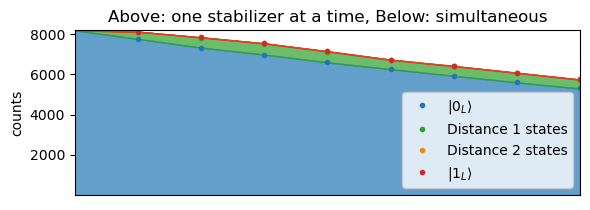

In [1]:
# %%
import pickle

import numpy as np
from matplotlib import colors as clrs  # TODO: Fix
from matplotlib import pyplot as plt
from qiskit.quantum_info import DensityMatrix, Statevector
from qiskit.quantum_info.states.measures import state_fidelity

from simulator_program import post_process, post_select
from simulator_program.custom_noise_models import (GateTimes, standard_times,
                                                   standard_times_delay,
                                                   thermal_relaxation_model_V2)
from simulator_program.data_analysis_tools import (default_execute,
                                                   overlap_with_subspace)
from simulator_program.idle_noise import add_idle_noise_to_circuit
from simulator_program.stabilizers import (get_full_stabilizer_circuit,
                                           get_snapshot_label,
                                           get_weight_1_basis,
                                           get_weight_2_basis, label_counter,
                                           logical_states, syndrome_table)

# %% Setup


def persist_to_file(file_name, overwrite=False):
    """Decorator to cache the simulation results
    """
    def decorator(original_func):
        try:
            cache = pickle.load(open(file_name, "rb"))
        except (IOError, ValueError):
            cache = {}

        def new_func(kwargs, T1, T2, gate_times):
            key = (frozenset(kwargs.items()), str(T1), str(
                T2), frozenset(gate_times.gate_times.items()))
            if key not in cache or overwrite:
                cache[key] = original_func(kwargs, T1, T2, gate_times)
                pickle.dump(cache, open(file_name, "wb"))
            else:
                print('Loading simulation results from file')
            return cache[key]
        return new_func

    return decorator


def check_if_saved(kwargs, T1, T2, gate_times, file_name='decoding_data/cache.dat'):
    key = (frozenset(kwargs.items()), str(T1), str(
        T2), frozenset(gate_times.gate_times.items()))
    return key in pickle.load(open(file_name, "rb"))


logical = logical_states(None)
weight_1 = get_weight_1_basis()
weight_2 = get_weight_2_basis()

# Calculate table of how each of the 32 different basis states (labeled by syndrome plus Z_L) map onto eachother from the 16 corrections
basis = [Statevector(logical[0]), *weight_1,
         Statevector(logical[1]), *weight_2]
basis_mapping_table = np.zeros((16, 32), dtype=int)
for basis_index in range(32):
    overlap = np.empty(16)
    for correction in range(16):
        state = basis[basis_index]
        for syndrome in syndrome_table[correction]:
            state = state.evolve(syndrome[0](), [syndrome[1]])
        for i in range(32):
            if state_fidelity(state, basis[i]):
                basis_mapping_table[correction, basis_index] = i
                break


def reduce_key(key: str, current_snapshot: int, measurements_per_snapshot=1):
    """Cuts of the initial bits of a key to get the equivalent one at earlier cycles. 

    E.g. \n
    current_cycle = 1 \n
    '0xff' -> '11111111' -> '1111' - > '0xf'  \n
    current_cycle = 3 \n
    '0xff' -> '11111111' -> '11111111' -> '0xff' \n

    Args:
        key (str): Hex key for the measurement outcome
        current_snapshot (int): Index of the snapshot
        measurements_per_snapshot (int, optional): Number of measurements (to different cl registers) that takes place in between every snapshot. Defaults to one. If only one snap is take every cycle, set this to the number of stabilizers.

    Returns:
        reduced key (str): Hex key matching the current cycle.
    """
    return hex(int(bin(int(key, 16))[2:][:measurements_per_snapshot*current_snapshot].zfill(1), 2))


def extract_syndrome(key, cycle, num_stab_gens=4):
    """Extracts the 4-bit syndrome that would normally be used to perform correction
    out of the key.

    E.g. 
    cycle = 0, num_stab_gens = 5, key = 24 = int('11000',2) -> 8 = int('1000',2)
    cycle = 1, num_stab_gens = 4, key = 136 = int('11001000',2) -> 12 = int('1100',2)
    cycle = 1, num_stab_gens = 5, key = 920 = int('1110000000',2) -> 12 = int('1100',2)

    Args:
        key (int): Integer specifying measurement being conditioned on.
        cycle ([type]): [description]
        num_stab_gens ([type]): [description]
    """
    return (key % (2**(num_stab_gens*(cycle))*2**4))//2**(num_stab_gens*cycle)


""" Below are functions for computing which snapshot is which. 
Formula:
There is one snap at the start (post encoding)
One after each cycle
One after each generator measurement (num_stab_gens in tot) 
And idle_snapshots before of after the stabilziers
"""


def get_cycle_indices():
    """Returns index of the end of each cycle (final stabilizer measurement)."""
    num_snaps_per_cycle = 1+kwargs['idle_snapshots'] + \
        kwargs['generator_snapshot']*num_stab_gens
    cycle_end_indices = np.array(
        [num_snaps_per_cycle*(cycle+1) for cycle in range(kwargs['n_cycles'])])
    if kwargs['idle_delay'] == 'after':
        cycle_end_indices -= kwargs['idle_snapshots']
    return cycle_end_indices


def get_stab_datapoints():
    """Returns indices of the snapshots of stabilizer generators. If these are disables, it instead
    returns the index of the end of the cycle.

    Returns:
        [list]: Indices of the stabilizer measurement snapshots.
    """

    snaps_per_cycle = 1+kwargs['idle_snapshots'] + \
        kwargs['generator_snapshot']*num_stab_gens
    if kwargs['generator_snapshot']:
        stab_indices_in_cycle = [i+1 for i in range(num_stab_gens)]
        # stab_indices_in_cycle = [i+1 for i in range(num_stab_gens)] if kwargs['idle_delay']=='after' else [i+1+kwargs['idle_snapshots'] for i in range(num_stab_gens)]
    else:
        stab_indices_in_cycle = [1]
    if kwargs['idle_delay'] == 'before':
        stab_indices_in_cycle = [value + kwargs['idle_snapshots']
                                 for value in stab_indices_in_cycle]

    stab_indices = []
    for cycle in range(0, kwargs['n_cycles']):
        stab_indices += [value + snaps_per_cycle *
                         (cycle) for value in stab_indices_in_cycle]
    return stab_indices


colors_def = plt.get_cmap("tab10")


def colors(i):
    if i == 1:
        i = 2
    elif i == 2:
        i = 1
    return colors_def(i)
# def colors(i):
#     return get_cmap('Spectral_r')(50*i+20)


# %% Print what simulations have been saved
for key in pickle.load(open('decoding_data/cache.dat', "rb")):
    print(key[0])
    print(key[1])
    print(key[3], '\n')
# kwargs = {k:v for k,v in {('idle_delay', 'before'), ('include_barriers', True), ('include_fifth_stabilizer', False), ('n_cycles', 3), ('generator_snapshot', True), ('encoding', False), ('reset', True), ('idle_snapshots', 2), ('conditional', False), ('recovery', True), ('final_measure', False)}}
# %% Simulation settings
kwargs = {
    'n_cycles': 2,
    'reset': True,
    'recovery': False,
    'encoding': False,
    'conditional': True,
    'include_barriers': True,
    'generator_snapshot': True,
    'idle_snapshots': 2,
    'final_measure': False,
    'idle_delay': 'before',
    'include_fifth_stabilizer': False}
# Define our registers (Maybe to be written as function?)

num_stab_gens = 4 + kwargs['include_fifth_stabilizer']

T1 = [40e3]*5+[100000000000, 100000000000]
T2 = [60e3]*5+[100000000000, 100000000000]
# T1 = 40e3
# T2 = 60e3
# gate_times = standard_times_delay
gate_times = standard_times  # .get_gate_times({'feedback':0})
# gate_times = GateTimes(0, 0, {'delay': 3310})

n_shots = 1024*8

print('Is a run with these settings saved?', check_if_saved(
    kwargs, T1, T2, gate_times, file_name='decoding_data/cache.dat'))
# %% Simulate
# Get the complete circuit
# Whether to ignore existing simulation data and overwrite with a new simulation
overwrite = False

@persist_to_file('decoding_data/cache.dat', overwrite)
def simulate(kwargs, T1, T2, gate_times):
    print('Simulating new data')
    # Create circuit
    circ = get_full_stabilizer_circuit(**kwargs)
    circ, times = add_idle_noise_to_circuit(
        circ, gate_times, T1=T1, T2=T2, return_time=True)
    # display(circ.draw(output='mpl'))
    # Run it
    noise_model = thermal_relaxation_model_V2(
        T1=T1, T2=T2, gate_times=gate_times)
    results = default_execute(
        circ, n_shots, gate_times=gate_times, noise_model=noise_model)
    return results, times


results, times = simulate(kwargs, T1, T2, gate_times)
num_snapshots = get_cycle_indices()[-1]+1
# %% Plot fidelity over time
time = np.empty(num_snapshots)
P_0 = np.empty(num_snapshots)
P_1 = np.empty(num_snapshots)
P_w1 = np.empty(num_snapshots)
P_w2 = np.empty(num_snapshots)
# P = np.empty(num_snapshots)
# order = np.empty((32,num_snapshots))
# TODO: Make work with delay snapshots for key other than '0x0'
# (can't accept measurements less often than once per snapshot)
key = '0x0'
for i in range(num_snapshots):
    label = get_snapshot_label('dm', kwargs['conditional'], i)
    if kwargs['conditional']:
        rho = results.data()[label][reduce_key(key, i)]
    else:
        rho = results.data()[label]
    time[i] = times[label]/1000

    P_0[i] = overlap_with_subspace(rho, logical[0])
    P_1[i] = overlap_with_subspace(rho, logical[1])
    P_w1[i] = overlap_with_subspace(rho, weight_1)
    P_w2[i] = overlap_with_subspace(rho, weight_2)
    # P[i] = overlap_with_subspace(rho, logical)
    # for j in range(32):
    #     order[j,i] = state_fidelity(rho,basis[j])

order = np.array([P_0, P_w1, P_w2, P_1])

stab_datapoints = get_stab_datapoints()
if kwargs['conditional']:
    counts_at_snapshots = post_select.get_trivial_post_select_counts_V2(
        results.get_counts(), stab_datapoints, num_snapshots)
else:
    counts_at_snapshots = np.ones(num_snapshots)

fig, ax = plt.subplots(1, 1, figsize=(6, 2.2))

for i in range(len(order)):
    lower = order[:i].sum(axis=0)
    ax.fill_between(time, (order[i]+lower)*counts_at_snapshots, lower*counts_at_snapshots,
                     color=np.array(colors(i))-np.array([0, 0, 0, 0.3]))
for i in range(len(order)):
    lower = order[:i].sum(axis=0)
    # Picks out the data points belonging to only the generators
    ax.plot(time[stab_datapoints], ((order[i]+lower) *
                                     counts_at_snapshots)[stab_datapoints], '.', color=colors(i))

if kwargs['conditional']:
    ax.set_ylabel('counts')
else:
    ax.set_ylabel(r'Overlap with subspace')
# ax.set_xlabel('Time [μs]')
ax.set_xticks([])
ax.set_ylim((0.5, counts_at_snapshots[0]))
ax.set_xlim((0, time[-1]))
ax.legend(labels=[r'$|0_L\rangle$', 'Distance 1 states', 'Distance 2 states', r'$|1_L\rangle$'],loc=4)
ax.set_title('Above: one stabilizer at a time, Below: simultaneous')
fig.tight_layout()
plt.show()

# Decoding errors
The main bottleneck of the code comes from the fact that we need to measure one generator at a time. This is not the case for other stabilizer codes, e.g. the surface code where this can be done in parallell. The system starts in an error-free $'0000'$ state. If, e.g. the error $Y_4$, which is identified by the syndrome $'1111'$, occurs in between the second and the third stabilizer measurement, then the two first (rightmost) bits would be incorrectly identified as zeros, causing the syndrome to be read as $'1100'$. If one then tries to correct using this syndromes, which corresponds to an $X_5$ error, it will effectively cause two errors.

## In more detail
The $[\![5,1,3]\!]$ code is constructed in such a way that starting from a logical state $\alpha\ket{0_L}+\beta\ket{1_L}$, every single-qubit pauli operator $E$ will map the state to a *unique* orthagonal subspace. One can then measure which of these orthagonal subspaces the state resides in and map it back to the codespace without affecting the underlying state.

The codepace is 2-dimensional, and this property requires an additional 2-dimensional orthogonal subspace for every Pauli operator. There are three (X, Y and Z) Pauli operators for each qubit, which requires $2 \cdot (1+3\cdot5) = 32$ dimensions. This is exactly sattisfied by the $2^5=32$ dimensional Hilbert space. The $[\![5,1,3]\!]$ code is the smallest where this is possible. 